In [13]:
import torch
import torchvision.models as models
from PIL import Image
from skimage.transform import resize
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import copy

# Импорт модуля для расчета матрицы Кирхгофа (Laplacian matrix) 
from closed_form_matting import compute_laplacian

%matplotlib inline

In [14]:
idx = 1
path = 'examples/'

#размер картинки можно поставить побольше если есть доступ к высокопроизводительным
#графическим картам
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = (461, 590) if torch.cuda.is_available() else (128, 128)

In [15]:
# Определим функции предобработки данных. Функции оптимизированны для работы с GPU (cuda)

def tensor_to_image(x):
    """
    Трансформируем torch.Tensor в np.array
        (1, C, W, H) -> (W, H, C)
        (B, C, W, H) -> (B, W, H, C) 

    """
    return x.cpu().detach().numpy().transpose(0, 2, 3, 1).squeeze().clip(0, 1)


def image_to_tensor(x):
    """
        Трасформируем np.array в torch.cuda.FloatTensor
        (W, H)       -> (1, 1, W, H)
        (W, H, C)    -> (1, C, W, H)
        (B, W, H, C) -> (B, C, W, H)

    """
    if x.ndim == 2:
        return torch.cuda.FloatTensor(x).unsqueeze(0).unsqueeze(0)
    if x.ndim == 3:
        return torch.cuda.FloatTensor(x.transpose(2, 0, 1)).unsqueeze(0)
    if x.ndim == 4:
        return torch.cuda.FloatTensor(x.transpose(0, 3, 1, 2))
    raise RuntimeError("np.array's ndim is out of range 2, 3 or 4.")


def extract_masks(segment):
    """
    Функция получает сегментационные маски из сегментированного изображения
    Допустимые цвета (англ):
        blue, green, black, white, red,
        yellow, grey, light_blue, purple.
    """
    extracted_colors = []

    # BLUE
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # GREEN
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # BLACK
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # WHITE
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # RED
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # YELLOW
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # GREY
    mask_r = (segment[..., 0] > 0.4) & (segment[..., 0] < 0.6)
    mask_g = (segment[..., 1] > 0.4) & (segment[..., 1] < 0.6)
    mask_b = (segment[..., 2] > 0.4) & (segment[..., 2] < 0.6)
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # LIGHT_BLUE
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # PURPLE
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    return extracted_colors


def get_all_masks(path):
    """
    Возвращает все сегментационные маски из всех сегментированных изображений
    """
    image = Image.open(path)
    np_image = np.array(image, dtype=np.float) / 255
    return extract_masks(np_image)


def is_nonzero(mask, thrs=0.01):
    """
    Проверка по порогу что маска существует
    """
    return np.sum(mask) / mask.size > thrs


def get_masks(path_style, path_content):
    """
    Возвращает все сегментационные маски с проверкой на существование маски
    """
    masks_style = get_all_masks(path_style)
    masks_content = get_all_masks(path_content)

    non_zero_masks = [
        is_nonzero(mask_c) and is_nonzero(mask_s)
        for mask_c, mask_s in zip(masks_content, masks_style)
    ]

    masks_style = [mask for mask, cond in zip(masks_style, non_zero_masks) if cond]
    masks_content = [mask for mask, cond in zip(masks_content, non_zero_masks) if cond]

    return masks_style, masks_content


def resize_masks(masks_style, masks_content, size):
    """
    Изменяет размер масок
    """
    resize_mask = lambda mask: resize(mask, size, mode="reflect")

    masks_style = [resize_mask(mask) for mask in masks_style]
    masks_content = [resize_mask(mask) for mask in masks_content]

    return masks_style, masks_content


def masks_to_tensor(masks_style, masks_content):
    """
    Трансформирует маски в torch.Tensor из np.array.
    """
    masks_style = [image_to_tensor(mask) for mask in masks_style]
    masks_content = [image_to_tensor(mask) for mask in masks_content]

    return masks_style, masks_content


def masks_loader(path_style, path_content, size):
    """
    Загружает маски.
    """
    style_masks, content_masks = get_masks(path_style, path_content)
    style_masks, content_masks = resize_masks(style_masks, content_masks, size)
    style_masks, content_masks = masks_to_tensor(style_masks, content_masks)

    return style_masks, content_masks


def image_loader(image_name, size):
    """
    Загружает картинки.
    """
    loader = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image


def plt_images(
    style_img,
    output_img,
    content_img,
    style_title="Style Image",
    output_title="Output Image",
    content_title="Content Image",
):
    """
    Выводим картинки контента, стиля, выходную для лучшего сравнения.
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(tensor_to_image(style_img))
    plt.title("Style Image")

    plt.subplot(1, 3, 2)
    plt.imshow(tensor_to_image(output_img))
    plt.title("Output Image")

    plt.subplot(1, 3, 3)
    plt.imshow(tensor_to_image(content_img))
    plt.title("Content Image")

    plt.tight_layout()
    plt.show()

In [41]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std


class ContentLoss(nn.Module):
    """
    Подсчет функции потерь контента
    """

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


def gram_matrix(input):
    """
    Функция подсчета матрицы Грама
    """
    B, C, H, W = input.size()
    features = input.view(B * C, H * W)
    gram = torch.mm(features, features.t())

    return gram.div(B * C * H * W)


class StyleLoss(nn.Module):
    """
    Функция потерь стиля
    """

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        gram = gram_matrix(input)
        self.loss = F.mse_loss(gram, self.target)
        return input


class AugmentedStyleLoss(nn.Module):
    """
    Дополненная функция потерь стиля, используются сегментационные маски
    """

    def __init__(self, target_feature, target_masks, input_masks):
        super(AugmentedStyleLoss, self).__init__()
        self.input_masks = [mask.detach() for mask in input_masks]
        self.targets = [
            gram_matrix(target_feature * mask).detach() for mask in target_masks
        ]

    def forward(self, input):
        gram_matrices = [
            gram_matrix(input * mask.detach()) for mask in self.input_masks
        ]
        self.loss = sum(
            F.mse_loss(gram, target)
            for gram, target in zip(gram_matrices, self.targets)
        )
        return input

class TVLoss(nn.Module):
"""
    Функция потерь вариаций (Total Variation (TV) Loss)
"""

    def __init__(self):
        super(TVLoss, self).__init__()
        self.ky = np.array([
            [[0, 0, 0],[0, 1, 0],[0,-1, 0]],
            [[0, 0, 0],[0, 1, 0],[0,-1, 0]],
            [[0, 0, 0],[0, 1, 0],[0,-1, 0]]
        ])
        self.kx = np.array([
            [[0, 0, 0],[0, 1,-1],[0, 0, 0]],
            [[0, 0, 0],[0, 1,-1],[0, 0, 0]],
            [[0, 0, 0],[0, 1,-1],[0, 0, 0]]
        ])
        self.conv_x = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv_x.weight = nn.Parameter(torch.from_numpy(self.kx).float().unsqueeze(0).to(device),
                                          requires_grad=False)
        self.conv_y = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv_y.weight = nn.Parameter(torch.from_numpy(self.ky).float().unsqueeze(0).to(device),
                                          requires_grad=False)
    def forward(self, input):
        height, width = input.size()[2:4]
        gx = self.conv_x(input)
        gy = self.conv_y(input)

        # gy = gy.squeeze(0).squeeze(0)
        # cv2.imwrite('gy.png', (gy*255.0).to('cpu').numpy().astype('uint8'))
        # exit()

        self.loss = torch.sum(gx**2 + gy**2)/2.0
        return input
    

def get_style_model_and_losses(
    cnn,
    normalization_mean,
    normalization_std,
    style_layers,
    content_layers,
    style_img,
    content_img,
    style_masks,
    content_masks,
    device,
):
    """
    Assumptions:
        - cnn is a nn.Sequential
        - resize happens only in the pooling layers
    """
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []
    tv_losses = []

    model = nn.Sequential(normalization)
    
    tv_loss = TVLoss()
    model.add_module("tv_loss_{}".format(0), tv_loss)
    tv_losses.append(tv_loss)
    

    num_pool, num_conv = 0, 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            num_conv += 1
            name = "conv{}_{}".format(num_pool, num_conv)

        elif isinstance(layer, nn.ReLU):
            name = "relu{}_{}".format(num_pool, num_conv)
            layer = nn.ReLU(inplace=False)

        elif isinstance(layer, nn.MaxPool2d):
            num_pool += 1
            num_conv = 0
            name = "pool_{}".format(num_pool)
            layer = nn.AvgPool2d(   # нелинейность через AvgPooling как в статье Gatys
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
            )

            # Update the segmentation masks to match
            # the activation matrices of the neural responses.
            style_masks = [layer(mask) for mask in style_masks]
            content_masks = [layer(mask) for mask in content_masks]

        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn{}_{}".format(num_pool, num_conv)

        else:
            raise RuntimeError(
                "Unrecognized layer: {}".format(layer.__class__.__name__)
            )

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(num_pool), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()

            style_loss = AugmentedStyleLoss(target_feature, style_masks, content_masks)
            model.add_module("style_loss_{}".format(num_pool), style_loss)
            style_losses.append(style_loss)

    # Trim off the layers after the last content and style losses
    # to speed up forward pass.
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss, AugmentedStyleLoss)):
            break

    model = model[: (i + 1)]

    return model, style_losses, content_losses, tv_losses


def get_input_optimizer(input_img):
    optimizer = optim.Adam([input_img.requires_grad_()], lr = 6e-3, weight_decay = 1e-2) #LBFGS
    return optimizer


def run_style_transfer(
    cnn,
    normalization_mean,
    normalization_std,
    style_layers,
    content_layers,
    style_img,
    content_img,
    input_img,
    style_masks,
    content_masks,
    device,
    reg=False,
    num_steps=300,
    style_weight=100000,
    content_weight=1000,
    reg_weight=1000,
    tv_weight = 1000
):
    """
    Запуск процесса переноса стиля.
    `reg_weight` параметр регуляризации фотореализма
    """
    model, style_losses, content_losses, tv_losses = get_style_model_and_losses(
        cnn,
        normalization_mean,
        normalization_std,
        style_layers,
        content_layers,
        style_img,
        content_img,
        style_masks,
        content_masks,
        device,
    )
    optimizer = get_input_optimizer(input_img)

    if reg:
        # вычисляем матрицу Киргохфа (Laplacian Matrix)
        L = compute_laplacian(tensor_to_image(content_img))

        def regularization_grad(input_img):
            """
            Вычисляем функцию потерь регуляризации фотореализма
            """
            im = tensor_to_image(input_img)
            grad = L.dot(im.reshape(-1, 3))
            loss = (grad * im.reshape(-1, 3)).sum()
            return loss, 2. * grad.reshape(*im.shape)

    step = 0
    while step <= num_steps:

        def closure():
            """
            https://pytorch.org/docs/stable/optim.html#optimizer-step-closure
            """
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            get_loss = lambda x: x.loss
            style_score = style_weight * sum(map(get_loss, style_losses))
            content_score = content_weight * sum(map(get_loss, content_losses))
            tv_score = tv_weight * sum(map(get_loss, tv_losses))

            loss = style_score + content_score + tv_score
            loss.backward()

            # Add photorealistic regularization
            if reg:
                reg_loss, reg_grad = regularization_grad(input_img)
                reg_grad_tensor = image_to_tensor(reg_grad)

                input_img.grad += reg_weight * reg_grad_tensor

                loss += reg_weight * reg_loss
                

            nonlocal step
            step += 1

            if step % 50 == 0:
                print(
                    "step {:>4d}:".format(step),
                    "S: {:.3f} C: {:.3f} TV:{:.3f} R:{:.3f}".format(
                        style_score.item(), content_score.item(), tv_score.item(), reg_loss if reg else 0
                    ),
                )

            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

#### Get images

In [42]:
style_img = image_loader(path + 'style/tar{}.png'.format(idx), imsize).to(device, torch.float)
content_img = image_loader(path + 'input/in{}.png'.format(idx), imsize).to(device, torch.float)
input_img = content_img.clone()

style_masks, content_masks = masks_loader(
    path + 'segmentation/tar{}.png'.format(idx),
    path + 'segmentation/in{}.png'.format(idx),
    imsize)

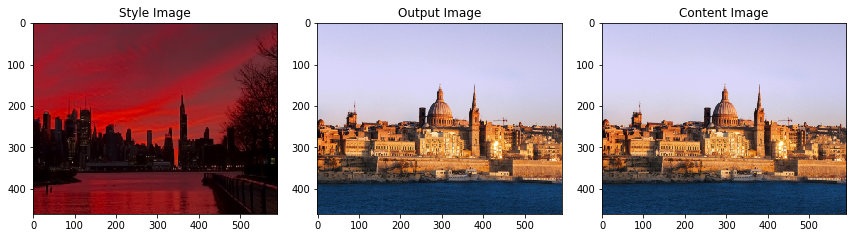

In [43]:
plt_images(style_img.cpu(), input_img.cpu(), content_img.cpu())

#### Загружаем VGG19

VGG19 обучена с определенной нормализацией. 
Мы ее используем также для нормализации наших картинок.
Для рассчета функции потерь стиля исползуем карты акцтивации со слоев "conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1".
Для контента - слой "conv4_2"

In [44]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
content_layers = ["conv4_2"]

- - - 

#### reg=False

In [45]:
#%%time

#output = run_style_transfer(
#   vgg,
#    vgg_normalization_mean,
#    vgg_normalization_std,
#    style_layers,
#    content_layers,
#    style_img,
#    content_img,
#    input_img,
#    style_masks,
#    content_masks,
#    device,
#    reg=False,
#    style_weight=1e7,
#    content_weight=1e4,
#    reg_weight=0,
#    num_steps=5000,
#)

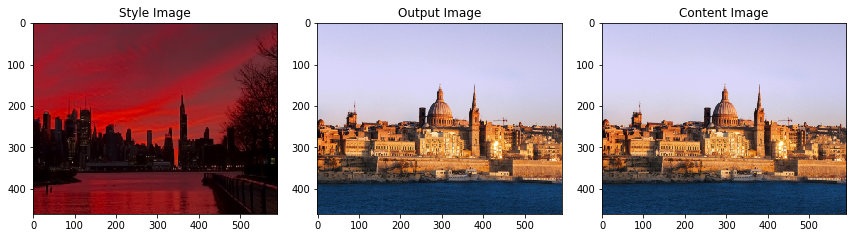

In [46]:
plt_images(style_img, input_img, content_img)

In [47]:
#### reg=True, num_steps=500

In [57]:
%%time

output = run_style_transfer(
    vgg,
    vgg_normalization_mean,
    vgg_normalization_std,
    style_layers,
    content_layers,
    style_img,
    content_img,
    input_img,
    style_masks,
    content_masks,
    device,
    reg=True,
    style_weight=1e7,
    content_weight=1e4,
    reg_weight=3e-5,
    num_steps=2000,
    tv_weight = 1e-4
)

step   50: S: 109.104 C: 24.788 TV:2.836 R:4713.128
step  100: S: 79.973 C: 22.823 TV:2.379 R:4036.176
step  150: S: 71.836 C: 20.968 TV:2.264 R:3700.178
step  200: S: 67.732 C: 21.767 TV:2.206 R:3455.008
step  250: S: 70.213 C: 27.282 TV:2.213 R:3314.108
step  300: S: 72.725 C: 27.275 TV:2.379 R:3299.320
step  350: S: 64.805 C: 26.384 TV:2.252 R:3098.785
step  400: S: 64.180 C: 22.213 TV:2.204 R:2956.080
step  450: S: 75.322 C: 35.919 TV:2.310 R:2969.264
step  500: S: 74.339 C: 28.017 TV:2.285 R:2923.092
step  550: S: 64.570 C: 25.627 TV:2.200 R:2751.334
step  600: S: 65.214 C: 31.943 TV:2.211 R:2670.654
step  650: S: 90.711 C: 49.317 TV:2.658 R:2938.032
step  700: S: 120.392 C: 40.776 TV:3.467 R:3505.673
step  750: S: 74.614 C: 24.944 TV:2.701 R:2959.086
step  800: S: 67.346 C: 23.709 TV:2.472 R:2730.723
step  850: S: 66.931 C: 31.732 TV:2.379 R:2607.636
step  900: S: 92.261 C: 50.757 TV:2.756 R:2836.907
step  950: S: 76.184 C: 30.429 TV:2.550 R:2711.834
step 1000: S: 68.723 C: 24.69

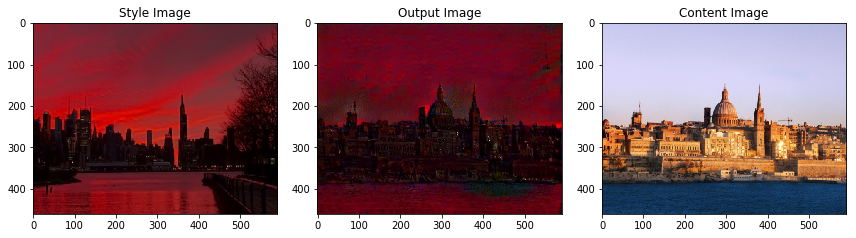

In [58]:
plt_images(style_img, input_img, content_img)